In [1]:
import mne
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

In [ ]:
eo_path = 'D:\\FY2025\\Fukuyama\\work place\\eeg-mri-aging-analysis\\data\\original_preprocessed_data\\sub-010002\\sub-010002_EO_eeg.fif'
ec_path = 'D:\\FY2025\\Fukuyama\\work place\\eeg-mri-aging-analysis\\data\\original_preprocessed_data\\sub-010002\\sub-010002_EC_eeg.fif'

In [3]:
# Define analysis parameters
freqs = np.arange(6, 30, 2)         # Frequency range: 6 to 28 Hz
n_cycles = freqs / 2                # Number of cycles per frequency
epoch_duration = 2.0                # Epoch length in seconds
epoch_i = 0                         # Epoch index for visualization
ch_i = 0                            # Channel index for visualization

In [4]:
def extract_subject_id_from_path(raw_path):
    """
    Extract subject ID like 'sub-010002' from a raw file path.

    Parameters:
    -----------
    raw_path : str
        Full path or filename containing subject ID.

    Returns:
    --------
    subject_id : str or None
        Extracted subject ID string, or None if not found.
    """
    filename = os.path.basename(raw_path)
    match = re.search(r'(sub-\d+)', filename)
    if match:
        return match.group(1)
    else:
        return None


In [5]:
def create_metadata(raw, csv_path):
    """
    Create metadata DataFrame for MNE Epochs object.

    Parameters:
    -----------
    raw : mne.io.Raw
        Raw EEG object, whose filename or annotations contain subject ID.
    csv_path : str
        Path to Participants_MPILMBB_LEMON.csv file.

    Returns:
    --------
    metadata : pd.DataFrame
        Metadata DataFrame with columns: ['ID', 'Gender', 'Age']
        Rows match the number of epochs.
    """
    # Load participant info CSV
    df = pd.read_csv(csv_path)

    # Rename for convenience
    df = df.rename(columns={
        'ID': 'ID',
        'Gender_ 1=female_2=male': 'Gender',
        'Age': 'Age'
    })

    # Extract subject ID from raw filename
    fname = os.path.basename(raw.filenames[0])
    subject_id = fname.split('_')[0]  # "sub-010002"

    # Filter for the subject
    sub_info = df[df['ID'] == subject_id]
    if sub_info.empty:
        raise ValueError(f"Subject ID {subject_id} not found in metadata CSV")

    gender = int(sub_info['Gender'].values[0])
    age = sub_info['Age'].values[0]

    # Repeat metadata for each epoch
    n_epochs = int(raw.n_times / (raw.info['sfreq'] * epoch_duration))  # approximate
    metadata = pd.DataFrame({
        'ID': [subject_id] * n_epochs,
        'Gender': [gender] * n_epochs,
        'Age': [age] * n_epochs
    })

    return metadata

In [6]:
raw = mne.io.read_raw_fif(eo_path, preload=True)

events = mne.make_fixed_length_events(raw, id=1, duration=epoch_duration)

epochs = mne.Epochs(raw, events, event_id=1, tmin=0, tmax=epoch_duration,
                        baseline=None, preload=True)
    
    
metadata = create_metadata(raw, 'D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\Participants_MPILMBB_LEMON.csv')
print(metadata)
epochs.metadata = metadata

<>:9: SyntaxWarning: invalid escape sequence '\F'
<>:9: SyntaxWarning: invalid escape sequence '\F'
C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_53632\4013018459.py:9: SyntaxWarning: invalid escape sequence '\F'
  metadata = create_metadata(raw, 'D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\Participants_MPILMBB_LEMON.csv')


Opening raw data file D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Range : 171871 ... 1331887 =     68.748 ...   532.755 secs
Ready.


C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_53632\4013018459.py:1: RuntimeWarning: This filename (D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eo_path, preload=True)


Reading 0 ... 1160016  =      0.000 ...   464.006 secs...


Not setting metadata
232 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 232 events and 5001 original time points ...
231 bad epochs dropped
             ID  Gender    Age
0    sub-010002       1  65-70
1    sub-010002       1  65-70
2    sub-010002       1  65-70
3    sub-010002       1  65-70
4    sub-010002       1  65-70
..          ...     ...    ...
227  sub-010002       1  65-70
228  sub-010002       1  65-70
229  sub-010002       1  65-70
230  sub-010002       1  65-70
231  sub-010002       1  65-70

[232 rows x 3 columns]


C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_53632\4013018459.py:9: SyntaxWarning: invalid escape sequence '\F'
  metadata = create_metadata(raw, 'D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\Participants_MPILMBB_LEMON.csv')


ValueError: metadata must have the same number of rows (232) as events (1)

In [9]:
# Function to process each condition
def process_condition(raw_file, title_prefix):
    # 1. Load raw EEG data
    raw = mne.io.read_raw_fif(raw_file, preload=True)

    # 2. Create fixed-length pseudo events every 2 seconds
    events = mne.make_fixed_length_events(raw, id=1, duration=epoch_duration)

    # 3. Epoching
    epochs = mne.Epochs(raw, events, event_id=1, tmin=0, tmax=epoch_duration,
                        baseline=None, preload=True)

    # 4. Time-frequency decomposition using Morlet wavelets
    power = mne.time_frequency.tfr_morlet(
        epochs, freqs=freqs, n_cycles=n_cycles,
        use_fft=True, return_itc=False, average=False
    )

    # 5. Extract amplitude and phase
    complex_data = power.data  # shape: (n_epochs, n_channels, n_freqs, n_times)
    amplitude_data = np.abs(complex_data) ** 2
    phase_data = np.angle(complex_data)

    # 6. Plot amplitude and phase for one epoch and one channel
    plt.figure(figsize=(12, 4))

    # Amplitude plot
    plt.subplot(1, 2, 1)
    plt.imshow(amplitude_data[epoch_i, ch_i], aspect='auto', origin='lower',
               extent=[0, epoch_duration, freqs[0], freqs[-1]], cmap='viridis')
    plt.title(f"{title_prefix} - Amplitude (μV)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar()

    # Phase plot
    plt.subplot(1, 2, 2)
    plt.imshow(phase_data[epoch_i, ch_i], aspect='auto', origin='lower',
               extent=[0, epoch_duration, freqs[0], freqs[-1]], cmap='twilight')
    plt.title(f"{title_prefix} - Phase (radians)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

Opening raw data file D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Range : 171871 ... 1331887 =     68.748 ...   532.755 secs
Ready.
Reading 0 ... 1160016  =      0.000 ...   464.006 secs...


C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_53632\3889080221.py:4: RuntimeWarning: This filename (D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_file, preload=True)


Not setting metadata
232 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 232 events and 5001 original time points ...
231 bad epochs dropped
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


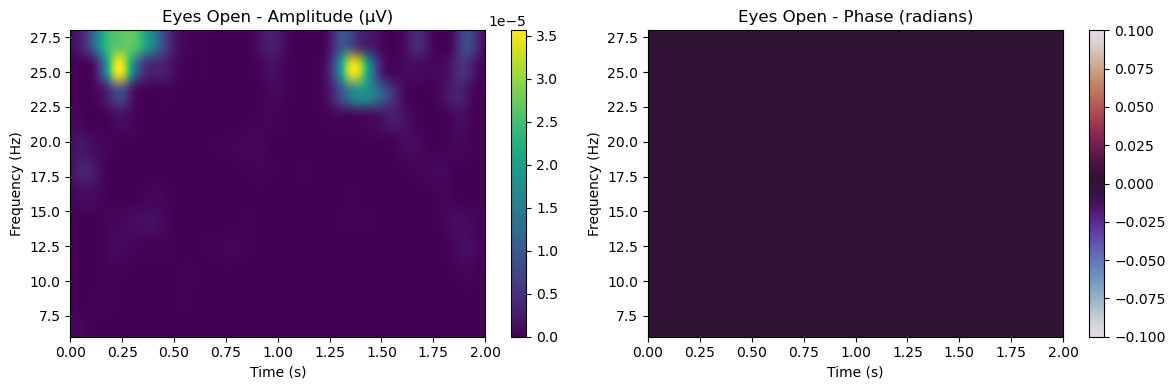

In [10]:
# Run for EO
process_condition(eo_path, title_prefix="Eyes Open")

Opening raw data file D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EC.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Range : 15962 ... 1175978 =      6.385 ...   470.391 secs
Ready.
Reading 0 ... 1160016  =      0.000 ...   464.006 secs...


C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_53632\3889080221.py:4: RuntimeWarning: This filename (D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_file, preload=True)


Not setting metadata
232 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 232 events and 5001 original time points ...
231 bad epochs dropped
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


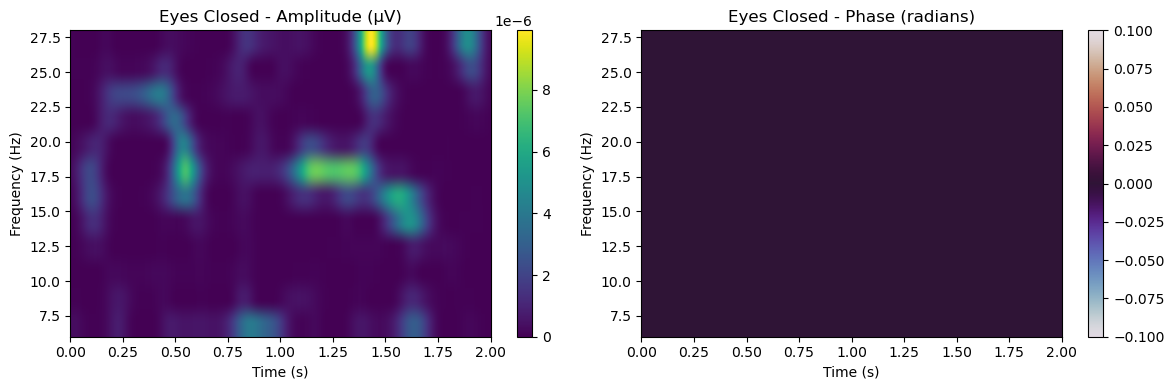

In [11]:
# Run for EC
process_condition(ec_path, title_prefix="Eyes Closed")

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import mne

def continuous_wavelet_transform(sig, sfreq, freqs, omega0=6.0, dj=0.125):
    dt = 1.0 / sfreq
    n = len(sig)
    n_cwt = int(2**np.ceil(np.log2(n)))  # 2のべき乗にゼロパディング

    s0 = 2.0 * dt
    J = int(np.log2(n_cwt * dt / s0) / dj)
    scales = s0 * 2**(dj * np.arange(0, J+1))
    
    x = np.zeros(n_cwt)
    x[:n] = sig - np.mean(sig)
    
    omega = 2.0 * np.pi * np.fft.fftfreq(n_cwt, dt)
    X = np.fft.fft(x)

    Hev = (omega > 0)
    cwt = np.zeros((len(scales), n_cwt), dtype=complex)

    for j, scale in enumerate(scales):
        Psi = np.sqrt(2.0*np.pi*scale/dt) * np.pi**(-0.25) * np.exp(-((scale*omega - omega0)**2) / 2.0) * Hev
        cwt[j, :] = np.fft.ifft(X * np.conjugate(Psi))
    
    cwt = cwt[:, :n]
    
    # スケールから周波数変換（近似）
    s_to_f = (omega0 + np.sqrt(2 + omega0**2)) / (4.0 * np.pi)
    freq_cwt = s_to_f / scales
    
    # 周波数が指定したfreqsに近くなるスケールだけを抽出
    idxs = [np.argmin(np.abs(freq_cwt - f)) for f in freqs]
    cwt_selected = cwt[idxs, :]
    
    return cwt_selected, freq_cwt[idxs]

# 関数を差し替えたprocess_condition
def process_condition_cwt(raw_file, title_prefix):
    raw = mne.io.read_raw_fif(raw_file, preload=True)

    events = mne.make_fixed_length_events(raw, id=1, duration=epoch_duration)

    epochs = mne.Epochs(raw, events, event_id=1, tmin=0, tmax=epoch_duration,
                        baseline=None, preload=True)

    sfreq = raw.info['sfreq']

    # 連続ウェーブレット変換を全epochs×channelsに適用（計算重いので注意）
    amplitude_data = []
    phase_data = []

    for epoch in epochs.get_data():  # shape: (n_channels, n_times)
        amp_ch = []
        ph_ch = []
        for ch_data in epoch:
            cwt_result, freq_selected = continuous_wavelet_transform(ch_data, sfreq, freqs)
            amp_ch.append(np.abs(cwt_result) ** 2)    # shape: (len(freqs), n_times)
            ph_ch.append(np.angle(cwt_result))
        amplitude_data.append(amp_ch)
        phase_data.append(ph_ch)

    amplitude_data = np.array(amplitude_data)  # shape: (n_epochs, n_channels, n_freqs, n_times)
    phase_data = np.array(phase_data)

    # プロット（例：epoch_i, ch_iを指定して表示）
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(amplitude_data[epoch_i, ch_i], aspect='auto', origin='lower',
               extent=[0, epoch_duration, freqs[0], freqs[-1]], cmap='viridis')
    plt.title(f"{title_prefix} - Amplitude (μV^2)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(phase_data[epoch_i, ch_i], aspect='auto', origin='lower',
               extent=[0, epoch_duration, freqs[0], freqs[-1]], cmap='twilight')
    plt.title(f"{title_prefix} - Phase (radians)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

Opening raw data file D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Range : 171871 ... 1331887 =     68.748 ...   532.755 secs
Ready.
Reading 0 ... 1160016  =      0.000 ...   464.006 secs...


C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_53632\690087890.py:41: RuntimeWarning: This filename (D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_file, preload=True)


Not setting metadata
232 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 232 events and 5001 original time points ...
231 bad epochs dropped


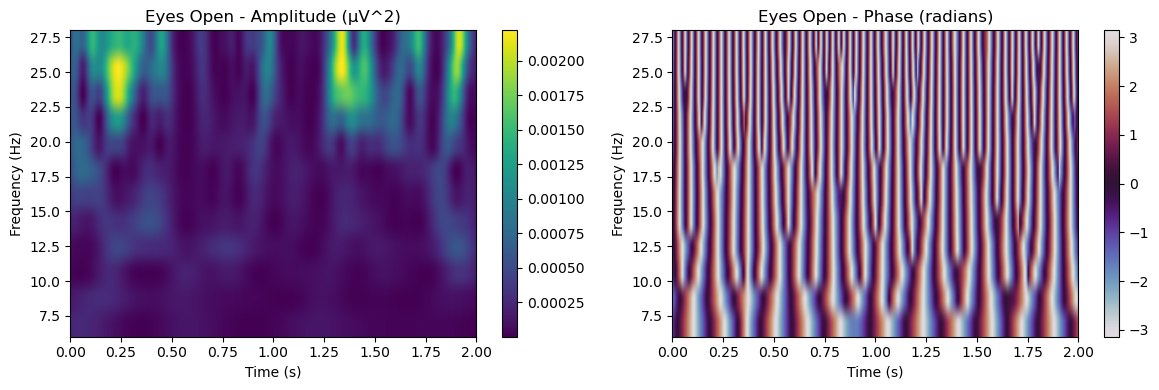

In [13]:
# Run for EO
process_condition_cwt(eo_path, title_prefix="Eyes Open")

Opening raw data file D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EC.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Range : 15962 ... 1175978 =      6.385 ...   470.391 secs
Ready.
Reading 0 ... 1160016  =      0.000 ...   464.006 secs...


C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_53632\690087890.py:41: RuntimeWarning: This filename (D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_file, preload=True)


Not setting metadata
232 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 232 events and 5001 original time points ...
231 bad epochs dropped


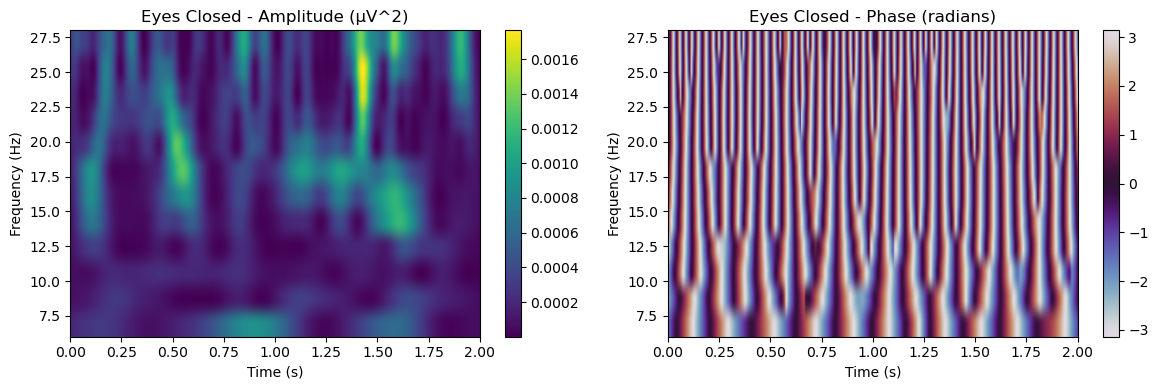

In [14]:
# Run for EC
process_condition_cwt(ec_path, title_prefix="Eyes Closed")

In [15]:
# Function to compute PLI from phase data
def compute_pli(phase_data):
    """
    phase_data: ndarray, shape = (n_epochs, n_channels, n_freqs, n_times)
        Instantaneous phase values (in radians) from time-frequency decomposition.

    Returns:
        pli_adj: ndarray, shape = (n_channels, n_channels, n_freqs)
        PLI adjacency matrix for each frequency between all channel pairs.
    """
    n_epochs, n_channels, n_freqs, n_times = phase_data.shape
    pli_adj_epochs = np.zeros((n_epochs, n_channels, n_channels, n_freqs))

    for ep in range(n_epochs):
        for f in range(n_freqs):
            phases = phase_data[ep, :, f, :]  # shape: (n_channels, n_times)
            for ch1 in range(n_channels):
                for ch2 in range(ch1, n_channels):
                    phase_diff = phases[ch1] - phases[ch2]
                    sign_sin = np.sign(np.sin(phase_diff))
                    pli = np.abs(np.mean(sign_sin))  # range [0, 1]
                    pli_adj_epochs[ep, ch1, ch2, f] = pli
                    pli_adj_epochs[ep, ch2, ch1, f] = pli  # symmetry

    pli_adj = np.mean(pli_adj_epochs, axis=0)  # Average over epochs
    return pli_adj

In [16]:
# Function to process one EEG condition and compute PLI
def process_condition(raw_file, title_prefix):
    # 1. Load raw EEG data
    raw = mne.io.read_raw_fif(raw_file, preload=True)

    # 2. Create pseudo-events every 2 seconds
    events = mne.make_fixed_length_events(raw, id=1, duration=epoch_duration)

    # 3. Epoching
    epochs = mne.Epochs(raw, events, event_id=1, tmin=0, tmax=epoch_duration,
                        baseline=None, preload=True)

    # 4. Time-frequency decomposition using Morlet wavelets
    power = mne.time_frequency.tfr_morlet(
        epochs, freqs=freqs, n_cycles=n_cycles,
        use_fft=True, return_itc=False, average=False
    )

    # 5. Extract amplitude and phase
    complex_data = power.data  # shape: (n_epochs, n_channels, n_freqs, n_times)
    amplitude_data = np.abs(complex_data) ** 2
    phase_data = np.angle(complex_data)

    # 6. Compute PLI adjacency matrix
    pli_matrix = compute_pli(phase_data)

    # (Optional) Plot example PLI matrix at a specific frequency index
    freq_idx = 5  # example: index for ~8 Hz
    plt.figure(figsize=(6, 5))
    plt.imshow(pli_matrix[:, :, freq_idx], vmin=0, vmax=1, cmap='hot')
    plt.title(f"{title_prefix} - PLI @ {freqs[freq_idx]} Hz")
    plt.xlabel("Channel")
    plt.ylabel("Channel")
    plt.colorbar(label="PLI")
    plt.tight_layout()
    plt.show()

    return pli_matrix

Opening raw data file D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Range : 171871 ... 1331887 =     68.748 ...   532.755 secs
Ready.
Reading 0 ... 1160016  =      0.000 ...   464.006 secs...


C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_53632\2086413776.py:4: RuntimeWarning: This filename (D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_file, preload=True)


Not setting metadata
232 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 232 events and 5001 original time points ...
231 bad epochs dropped
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


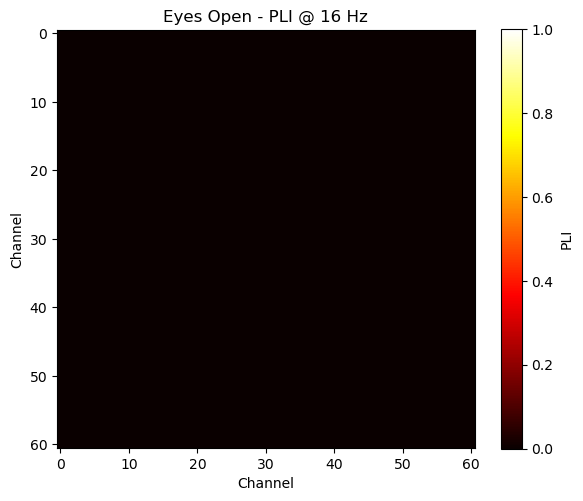

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [17]:
# Run for EO
process_condition(eo_path, title_prefix="Eyes Open")

In [18]:
def process_condition_cwt(raw_file, title_prefix):
    raw = mne.io.read_raw_fif(raw_file, preload=True)

    events = mne.make_fixed_length_events(raw, id=1, duration=epoch_duration)

    epochs = mne.Epochs(raw, events, event_id=1, tmin=0, tmax=epoch_duration,
                        baseline=None, preload=True)
    
    sfreq = raw.info['sfreq']

    # 連続ウェーブレット変換を全epochs×channelsに適用（計算重いので注意）
    amplitude_data = []
    phase_data = []

    for epoch in epochs.get_data():  # shape: (n_channels, n_times)
        amp_ch = []
        ph_ch = []
        for ch_data in epoch:
            cwt_result, freq_selected = continuous_wavelet_transform(ch_data, sfreq, freqs)
            amp_ch.append(np.abs(cwt_result) ** 2)    # shape: (len(freqs), n_times)
            ph_ch.append(np.angle(cwt_result))
        amplitude_data.append(amp_ch)
        phase_data.append(ph_ch)

    amplitude_data = np.array(amplitude_data)  # shape: (n_epochs, n_channels, n_freqs, n_times)
    phase_data = np.array(phase_data)

    # 6. Compute PLI adjacency matrix
    pli_matrix = compute_pli(phase_data)

    # (Optional) Plot example PLI matrix at a specific frequency index
    freq_idx = 5  # example: index for ~8 Hz
    plt.figure(figsize=(6, 5))
    plt.imshow(pli_matrix[:, :, freq_idx], vmin=0, vmax=1, cmap='hot')
    plt.title(f"{title_prefix} - PLI @ {freqs[freq_idx]} Hz")
    plt.xlabel("Channel")
    plt.ylabel("Channel")
    plt.colorbar(label="PLI")
    plt.tight_layout()
    plt.show()

    return pli_matrix

Opening raw data file D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Range : 171871 ... 1331887 =     68.748 ...   532.755 secs
Ready.
Reading 0 ... 1160016  =      0.000 ...   464.006 secs...


C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_53632\3817028457.py:2: RuntimeWarning: This filename (D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_file, preload=True)


Not setting metadata
232 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 232 events and 5001 original time points ...
231 bad epochs dropped


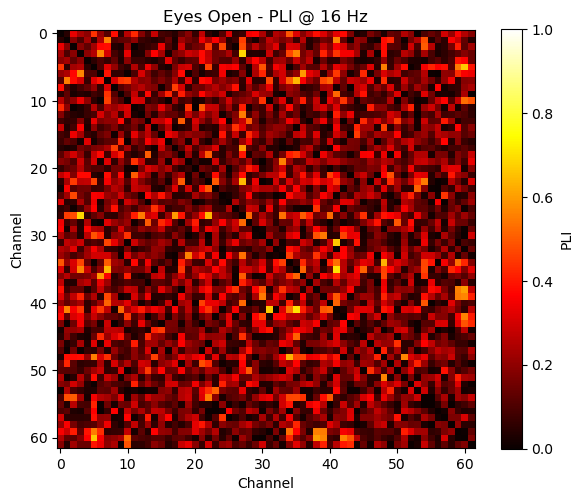

In [19]:
# Run for EO
psi_matrix_eo = process_condition_cwt(eo_path, title_prefix="Eyes Open")

Opening raw data file D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EC.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Range : 15962 ... 1175978 =      6.385 ...   470.391 secs
Ready.
Reading 0 ... 1160016  =      0.000 ...   464.006 secs...


C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_53632\3817028457.py:2: RuntimeWarning: This filename (D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_file, preload=True)


Not setting metadata
232 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 232 events and 5001 original time points ...
231 bad epochs dropped


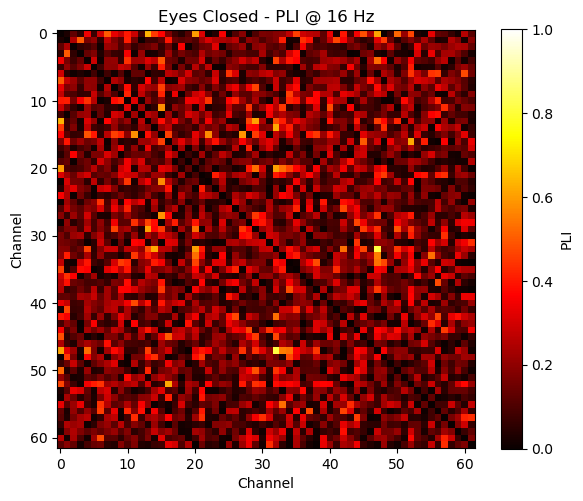

In [20]:
psi_matrix_ec = process_condition_cwt(ec_path, title_prefix="Eyes Closed")

In [21]:
def compute_ihps_odd_even(pli_matrix, ch_names, freq_idx):
    """
    Compute IHPS by averaging PLI between odd- and even-numbered EEG channels.

    Parameters:
    -----------
    pli_matrix : np.ndarray
        Shape (n_channels, n_channels, n_freqs), full PLI adjacency matrix.
    ch_names : list of str
        Channel name list (must match pli_matrix indexing).
    freq_idx : int
        Index of the frequency at which to compute IHPS.

    Returns:
    --------
    ihps_value : float
        Mean PLI between odd-numbered and even-numbered channels.
    """
    # Get channel indices for odd and even-numbered channels
    odd_idx = []
    even_idx = []
    
    for idx, name in enumerate(ch_names):
        match = re.search(r'(\d+)$', name)
        if match:
            num = int(match.group(1))
            if num % 2 == 1:
                odd_idx.append(idx)
            else:
                even_idx.append(idx)

    # Compute all PLI values between odd and even channels
    values = []
    for i in odd_idx:
        for j in even_idx:
            pli_val = pli_matrix[i, j, freq_idx]
            values.append(pli_val)

    ihps_value = np.mean(values) if values else np.nan
    return ihps_value

In [22]:
raw_ec = mne.io.read_raw_fif(ec_path, preload=True)
freq_idx = np.argmin(np.abs(freqs - 10))
ihps = compute_ihps_odd_even(psi_matrix_ec, raw_ec.info['ch_names'], freq_idx)
print(f"IHPS (odd-even) at {freqs[freq_idx]} Hz = {ihps:.3f}")

Opening raw data file D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EC.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Range : 15962 ... 1175978 =      6.385 ...   470.391 secs
Ready.
Reading 0 ... 1160016  =      0.000 ...   464.006 secs...


C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_53632\115343552.py:1: RuntimeWarning: This filename (D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ec = mne.io.read_raw_fif(ec_path, preload=True)


IHPS (odd-even) at 10 Hz = 0.250


In [23]:
raw_eo = mne.io.read_raw_fif(eo_path, preload=True)
freq_idx = np.argmin(np.abs(freqs - 10))
ihps = compute_ihps_odd_even(psi_matrix_eo, raw_eo.info['ch_names'], freq_idx)
print(f"IHPS (odd-even) at {freqs[freq_idx]} Hz = {ihps:.3f}")

Opening raw data file D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Range : 171871 ... 1331887 =     68.748 ...   532.755 secs
Ready.
Reading 0 ... 1160016  =      0.000 ...   464.006 secs...


C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_53632\1763890761.py:1: RuntimeWarning: This filename (D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EO.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_eo = mne.io.read_raw_fif(eo_path, preload=True)


IHPS (odd-even) at 10 Hz = 0.270


In [24]:
import networkx as nx

In [25]:
def analyze_network_from_psi(psi_matrix, threshold=0.3):
    """
    Analyze functional connectivity network from PSI (PLI or PLV) matrix.

    Parameters:
    -----------
    psi_matrix : ndarray
        Shape (n_channels, n_channels), PSI adjacency matrix at a given frequency.
    threshold : float
        Minimum value of PSI to consider an edge (binarization or sparsification).

    Returns:
    --------
    results : dict
        Dictionary containing centrality, efficiency metrics, etc.
    """
    # Thresholding (sparse graph)
    adj = np.copy(psi_matrix)
    adj[adj < threshold] = 0

    # Build weighted undirected graph
    G = nx.from_numpy_array(adj)

    # Compute graph metrics
    results = {}
    results['degree_centrality'] = nx.degree_centrality(G)
    results['betweenness_centrality'] = nx.betweenness_centrality(G, weight='weight')
    results['eigenvector_centrality'] = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
    results['node_strength'] = dict(G.degree(weight='weight'))

    # Efficiency
    results['global_efficiency'] = nx.global_efficiency(G)
    results['local_efficiency'] = nx.local_efficiency(G)

    return results

In [26]:
def compute_and_print_centralities(psi_matrix, ch_names, threshold=0.3):
    """
    Compute and print Degree, Betweenness, Eigenvector centralities.

    Parameters:
    -----------
    psi_matrix : np.ndarray
        2D weighted adjacency matrix (n_channels x n_channels)
    ch_names : list of str
        Channel names corresponding to nodes
    threshold : float
        Threshold to sparsify the matrix (edges < threshold removed)
    """

    # Thresholding to create sparse adjacency matrix
    adj = np.copy(psi_matrix)
    adj[adj < threshold] = 0

    # Create weighted undirected graph
    G = nx.from_numpy_array(adj)

    # Relabel nodes with channel names forわかりやすさ
    mapping = {i: ch for i, ch in enumerate(ch_names)}
    G = nx.relabel_nodes(G, mapping)

    # Compute centralities
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
    eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)

    # 出力
    print("Degree Centrality:")
    for ch, val in degree_centrality.items():
        print(f"  {ch}: {val:.4f}")

    print("\nBetweenness Centrality:")
    for ch, val in betweenness_centrality.items():
        print(f"  {ch}: {val:.4f}")

    print("\nEigenvector Centrality:")
    for ch, val in eigenvector_centrality.items():
        print(f"  {ch}: {val:.4f}")

In [27]:
ch_names = raw_ec.info['ch_names']
matrix_pli = psi_matrix_ec[:, :, freq_idx]

compute_and_print_centralities(matrix_pli, ch_names, threshold=0.3)

Degree Centrality:
  Fp1: 0.3934
  Fp2: 0.2131
  F7: 0.3443
  F3: 0.3443
  Fz: 0.2787
  F4: 0.3934
  F8: 0.3279
  FC5: 0.3279
  FC1: 0.3115
  FC2: 0.3279
  FC6: 0.2787
  T7: 0.4754
  C3: 0.0984
  Cz: 0.2787
  C4: 0.3770
  T8: 0.6230
  VEOG: 0.2459
  CP5: 0.2951
  CP1: 0.1803
  CP2: 0.5410
  CP6: 0.5246
  AFz: 0.2295
  P7: 0.3934
  P3: 0.2623
  Pz: 0.3443
  P4: 0.4262
  P8: 0.6557
  PO9: 0.2787
  O1: 0.2131
  Oz: 0.4098
  O2: 0.4262
  PO10: 0.3770
  AF7: 0.4426
  AF3: 0.2623
  AF4: 0.2951
  AF8: 0.3279
  F5: 0.2787
  F1: 0.2623
  F2: 0.2787
  F6: 0.3279
  FT7: 0.3115
  FC3: 0.4426
  FC4: 0.2295
  FT8: 0.4262
  C5: 0.1311
  C1: 0.2787
  C2: 0.4426
  C6: 0.3770
  TP7: 0.5574
  CP3: 0.2295
  CPz: 0.2459
  CP4: 0.5246
  TP8: 0.6393
  P5: 0.3770
  P1: 0.2787
  P2: 0.2951
  P6: 0.4098
  PO7: 0.3115
  PO3: 0.1475
  POz: 0.5574
  PO4: 0.4098
  PO8: 0.5082

Betweenness Centrality:
  Fp1: 0.0180
  Fp2: 0.0109
  F7: 0.0101
  F3: 0.0093
  Fz: 0.0044
  F4: 0.0074
  F8: 0.0098
  FC5: 0.0142
  FC1: 0.

In [28]:
matrix_pli = psi_matrix_ec[:, :, freq_idx]
net_metrics = analyze_network_from_psi(matrix_pli, threshold=0.3)

print("Global efficiency:", net_metrics['global_efficiency'])
print("Top hub nodes (degree):", sorted(net_metrics['node_strength'].items(), key=lambda x: -x[1])[:5])


Global efficiency: 0.6749515247664376
Top hub nodes (degree): [(52, 19.53389322135573), (26, 19.21735652869426), (15, 18.817836432713456), (20, 17.33613277344531), (51, 16.34273145370926)]


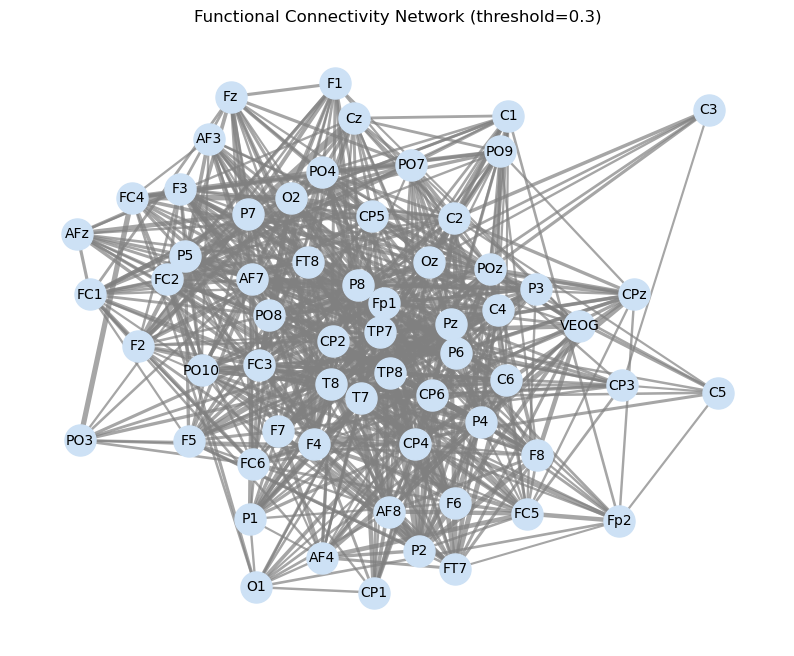

In [32]:
threshold = 0.3
#visualize_network_from_psi(matrix_pli, ch_names, threshold=0.3)

# 1. 閾値以下のエッジを0にして疎グラフに
adj = np.copy(matrix_pli)
adj[adj < threshold] = 0

# 2. NetworkXのグラフ作成（無向）
G = nx.from_numpy_array(adj)

# 3. ノード名にリネーム
mapping = {i: ch for i, ch in enumerate(ch_names)}
G = nx.relabel_nodes(G, mapping)

# 4. レイアウト計算（ノードの座標）
pos = nx.spring_layout(G, seed=42)

# 5. エッジの重み取得（0以外のみ）
edges = [(e[0], e[1]) for e in G.edges(data='weight') if e[2] > 0]
weights = [e[2] for e in G.edges(data='weight') if e[2] > 0]

# 6. 描画
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="#cde1f5")
nx.draw_networkx_labels(G, pos, font_size=10)

# エッジ幅を重みに比例させる（スケール調整）
edge_widths = [w * 5 for w in weights]

nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths, edge_color='gray', alpha=0.7)

plt.title(f'Functional Connectivity Network (threshold={threshold})')
plt.axis('off')
plt.show()

In [39]:
import numpy as np
import mne
from mne_connectivity.viz import plot_connectivity_circle

def plot_connectivity_circle_from_psi(psi_matrix, ch_names, title="Connectivity Circle Plot", threshold=0.3):
    """
    Plot connectivity circle plot from PSI matrix using MNE tools.

    Parameters:
    -----------
    psi_matrix : np.ndarray
        (n_channels, n_channels) functional connectivity matrix (e.g., PLI)
    ch_names : list of str
        Channel names corresponding to nodes
    title : str
        Title for the plot
    threshold : float
        Minimum connectivity value to show an edge
    """

    # 1. Threshold connectivity matrix for visualization
    matrix = np.copy(psi_matrix)
    matrix[matrix < threshold] = 0

    # 2. Extract edges and weights for MNE plot
    con = matrix

    # 3. Node colors (optional): 一律同じ色にする例
    node_colors = ['#1f77b4'] * len(ch_names)

    # 4. Create plot
    fig = plot_connectivity_circle(
        con,
        ch_names,
        n_lines=None,          # None: 全て表示（閾値でフィルター済み）
        node_colors=node_colors,
        title=title,
        colormap='viridis',
        facecolor='white',
        textcolor='black',
        fontsize_names=12,
    )

    return fig


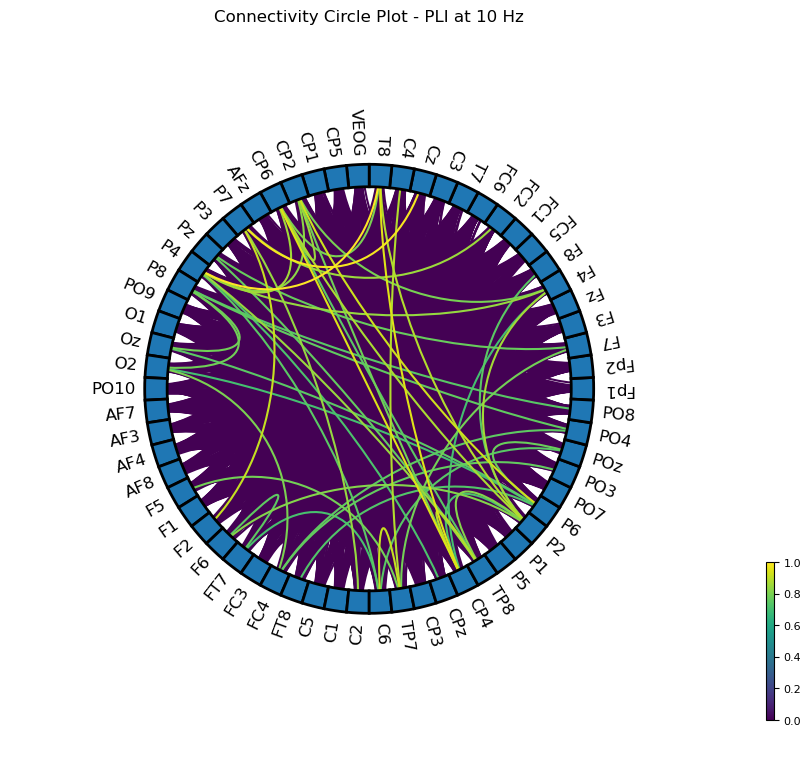

(<Figure size 800x800 with 2 Axes>,
 <PolarAxes: title={'center': 'Connectivity Circle Plot - PLI at 10 Hz'}>)

In [36]:
plot_connectivity_circle_from_psi(matrix_pli, ch_names, threshold=0.7, title="Connectivity Circle Plot - PLI at 10 Hz")

In [40]:
import mne
import numpy as np
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator

from mne_connectivity import phase_slope_index, seed_target_indices

In [ ]:
data = epochs.get_data()

In [45]:
from mne_connectivity import phase_slope_index


raw_ec = mne.io.read_raw_fif(ec_path, preload=True)

data = epochs.get_data()

# Step 3: PSIを評価する信号ペアのインデックスを指定
n_channels = data.shape[1]
indices = tuple(zip(*[(i, j) for i in range(n_channels) for j in range(n_channels) if i != j]))
print(f"Number of connections: {len(indices)}")

# Step 4: PSIの計算
psi = phase_slope_index(
    data=data,
    sfreq=epochs.info["sfreq"],
    mode="multitaper",
    fmin=10.0,
    fmax=20.0,
    indices=indices,
    tmin=0.0,
    n_jobs=1,
)

# 8. Access PSI result
psi_matrix = psi.get_data()  # shape: (n_connections, n_freqs)
connection_names = psi.names  # e.g., ["Fz-Pz", "Cz-Oz", ...]

Opening raw data file D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EC.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Range : 15962 ... 1175978 =      6.385 ...   470.391 secs
Ready.
Reading 0 ... 1160016  =      0.000 ...   464.006 secs...


C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_53632\2130220106.py:4: RuntimeWarning: This filename (D:\FY2025\Fukuyama\work place\eeg-mri-aging-analysis\data\original_preprocessed_data\sub-010002\sub-010002_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ec = mne.io.read_raw_fif(ec_path, preload=True)


Number of connections: 2
Estimating phase slope index (PSI)
Connectivity computation...
    computing connectivity for 3782 connections
    using t=0.000s..2.000s for estimation (5001 points)
    frequencies: 10.5Hz..20.0Hz (20 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherency
    computing cross-spectral density for epoch 1
[Connectivity computation done]
Computing PSI from estimated Coherency: <SpectralConnectivity | freq : [10.497900, 19.996001], , nave : 1, nodes, n_estimated : 62, 3782, ~1.4 MiB>
[PSI Estimation Done]


C:\Users\sFukuyama\AppData\Local\Temp\3\ipykernel_53632\1672408397.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', n_nodes)


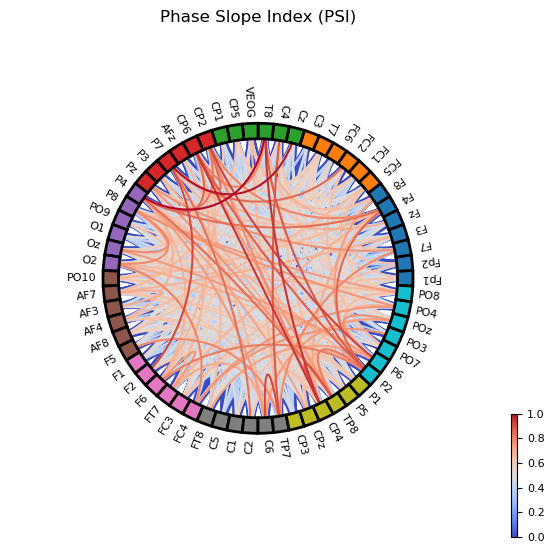

In [55]:
from mne_connectivity.viz import plot_connectivity_circle
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# (1) PSIデータ平均（周波数軸で平均）
psi_data = psi.get_data()  # shape: (n_connections, n_freqs)
psi_avg = psi_data.mean(axis=1)

n_nodes = len(epochs.ch_names)


matrix_pli = psi_matrix_ec[:, :, freq_idx]

# 1. Threshold connectivity matrix for visualization
threshold = 0.3
matrix = np.copy(matrix_pli)
matrix[matrix < threshold] = 0

cmap = cm.get_cmap('tab10', n_nodes)
node_colors = [cmap(i) for i in range(n_nodes)]

# (2) インデックスを [(src, tgt), ...] 形式に直す
con_indices = list(zip(psi.indices[0], psi.indices[1]))

# (3) 可視化
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
plot_connectivity_circle(
    con=matrix,
    node_names=epochs.ch_names,
    indices=con_indices,
    title="Phase Slope Index (PSI)",
    n_lines=None,  # 全接続を表示
    colormap='coolwarm',
    node_colors=node_colors,
    facecolor='white',
    textcolor='black',
    linewidth=1.5,
    fig=fig,
    ax=ax,
)
plt.show()

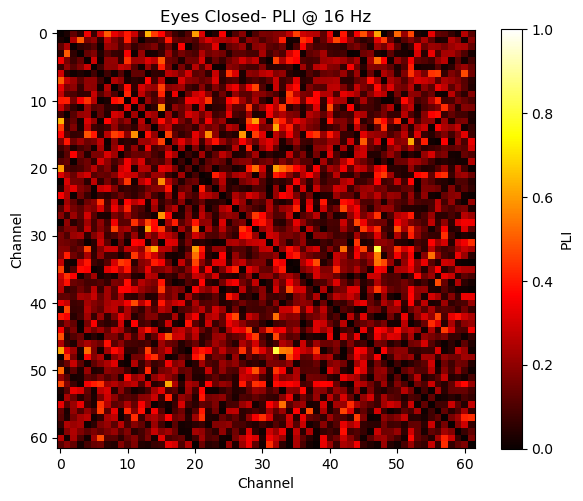

In [ ]:
# (Optional) Plot example PLI matrix at a specific frequency index
freq_idx = 5  # example: index for ~8 Hz
plt.figure(figsize=(6, 5))
plt.imshow(psi_matrix_ec[:, :, freq_idx], vmin=0, vmax=1, cmap='hot')
plt.title(f"Eyes Closed- PSI @ {freqs[freq_idx]} Hz")
plt.xlabel("Channel")
plt.ylabel("Channel")
plt.colorbar(label="PSI")
plt.tight_layout()
plt.show()